In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import seaborn as sns

data = pd.read_json('data/deplacements-presidents-republique-et-premiers-ministres-depuis-1945.json')

data.sample(2)

,fonction,individu,contenu_initial,lieu,lieu_normalise,pays,code_pays,date_de_debut,annee_du_voyage,date_de_fin,lieu_contours,url_de_la_notice,cote_du_dossier,geo_point_2d
1758,Premier ministre,Pierre Mauroy,Yougoslavie - Athenes. 15-17/10/1983,Athènes,None,Grèce,GRC,1983-10-15,1983,1983-10-17,"{'type': 'Feature', 'geometry': {'coordinates'...",https://www.siv.archives-nationales.culture.go...,19940280/44,"{'lon': 22.886605800427827, 'lat': 39.11847115..."
335,Premier ministre,Lionel Jospin,"Argentine / Brésil, 4-8 avril 2001",Brésil,None,Brésil,BRA,2001-04-4,2001,2001-04-8,"{'type': 'Feature', 'geometry': {'coordinates'...",https://www.siv.archives-nationales.culture.go...,"20050317/19, 20160201/36","{'lon': -53.09729008088172, 'lat': -10.7843067..."


## Null Values Analysis

In [2]:
print(f"\nThe null values by column are: \n{data.isnull().sum()}.")


The null values by column are: 
fonction               0
individu               0
contenu_initial        0
lieu                   0
lieu_normalise       929
pays                   0
code_pays              0
date_de_debut        102
annee_du_voyage        0
date_de_fin         1320
lieu_contours          4
url_de_la_notice       0
cote_du_dossier        0
geo_point_2d           4
dtype: int64.


### Find inconsistencies in null values

In [3]:
lieu_pairs = data[data.duplicated(subset=['lieu', 'lieu_normalise'], keep=False)]

inconsistent_data = lieu_pairs.groupby('lieu').filter(lambda x: x['lieu_normalise'].notnull().any() and x['lieu_normalise'].isnull().any())

if not inconsistent_data.empty:
    # it means that there are cases where 'lieu_normalise' has both null and populated values for same 'lieu'
    display(inconsistent_data.drop_duplicates(subset=['lieu', 'lieu_normalise']).sort_values(by=['lieu', 'lieu_normalise']))

,fonction,individu,contenu_initial,lieu,lieu_normalise,pays,code_pays,date_de_debut,annee_du_voyage,date_de_fin,lieu_contours,url_de_la_notice,cote_du_dossier,geo_point_2d
949,Président de la République,Nicolas Sarkozy,Alger et Constantine (Algérie) du 3 au 5 décem...,Algérie,Algérie,Algérie,DZA,None,2007,2007-12-05,"{'type': 'Feature', 'geometry': {'coordinates'...",https://www.siv.archives-nationales.culture.go...,20220621/9,"{'lon': 2.626614499993318, 'lat': 28.161801452..."
59,Président de la République,François Mitterrand,Algerie. 9 au 10/03/1989,Algérie,None,Algérie,DZA,1989-03-9,1989,1989-03-10,"{'type': 'Feature', 'geometry': {'coordinates'...",http://www.siv.archives-nationales.culture.gou...,19940280/29,"{'lon': 2.626614499993318, 'lat': 28.161801452..."
487,Premier ministre,François Fillon,Berlin (Allemagne) le 28 juin 2007.,Allemagne,Allemagne,Allemagne,DEU,None,2007,2008-12-12,"{'type': 'Feature', 'geometry': {'coordinates'...",https://www.siv.archives-nationales.culture.go...,20220621/17,"{'lon': 10.400329133037499, 'lat': 51.09747327..."
354,Président de la République,François Mitterrand,RFA le 11 octobre 1987,Allemagne,[République fédérale allemande (RFA)],Allemagne,DEU,1987-10-11,1987,None,"{'type': 'Feature', 'geometry': {'coordinates'...",http://www.siv.archives-nationales.culture.gou...,19980060/1,"{'lon': 10.400329133037499, 'lat': 51.09747327..."
1,Président de la République,François Mitterrand,Allemagne 20 juillet 1993,Allemagne,None,Allemagne,DEU,1993-07-20,1993,None,"{'type': 'Feature', 'geometry': {'coordinates'...",http://www.siv.archives-nationales.culture.gou...,19980060/5,"{'lon': 10.400329133037499, 'lat': 51.09747327..."
494,Premier ministre,François Fillon,Bruxelles (Belgique) le 19 juin 2008.,Belgique,Belgique,Belgique,BEL,None,2008,2008-06-07,"{'type': 'Feature', 'geometry': {'coordinates'...",https://www.siv.archives-nationales.culture.go...,20220621/20,"{'lon': 4.690063581484861, 'lat': 50.625725957..."
109,Président de la République,Jacques Chirac,"Tournée européenne en Belgique, au Luxembourg,...",Belgique,None,Allemagne,DEU,2000-11-22,2000,2000-11-30,"{'type': 'Feature', 'geometry': {'coordinates'...",http://www.siv.archives-nationales.culture.gou...,20160201/16,"{'lon': 10.400329133037499, 'lat': 51.09747327..."
186,Président de la République,Charles de Gaulle,"Bonn (RFA), obsèques nationales de l'ex Chance...",Bonn,[République fédérale allemande (RFA)],Allemagne,DEU,1967-04-25,1967,None,"{'type': 'Feature', 'geometry': {'coordinates'...",http://www.siv.archives-nationales.culture.gou...,19860020/43,"{'lon': 10.400329133037499, 'lat': 51.09747327..."
11,Président de la République,François Mitterrand,Bonn le 29-30 novembre 1994 consultations fran...,Bonn,None,Allemagne,DEU,1994-11-29,1994,1994-11-30,"{'type': 'Feature', 'geometry': {'coordinates'...",http://www.siv.archives-nationales.culture.gou...,19990049/1,"{'lon': 10.400329133037499, 'lat': 51.09747327..."
1460,Premier ministre,François Fillon,Québec les 18 et 19 octobre 2008.,Canada,Canada,Canada,CDN,None,2008,2008-10-19,"{'type': 'Feature', 'geometry': {'coordinates'...",https://www.siv.archives-nationales.culture.go...,20220621/21,"{'lon': -98.14238137209676, 'lat': 61.46907614..."


In [4]:
data.loc[
    (data['lieu'] == 'Bonn') | (data['lieu'] == 'Allemagne'),
    'lieu_normalise'
] = 'Allemagne'

data['lieu_normalise'].fillna(data['lieu'], inplace=True)

### Check date related nulls and date formatting issues

In [5]:
data.dropna()[data.date_de_debut.apply(lambda x: str(x)[:4]) != data.date_de_fin.apply(lambda x: str(x)[:4])]

C:\Users\nicol\AppData\Local\Temp\ipykernel_4576\4063810716.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data.dropna()[data.date_de_debut.apply(lambda x: str(x)[:4]) != data.date_de_fin.apply(lambda x: str(x)[:4])]


,fonction,individu,contenu_initial,lieu,lieu_normalise,pays,code_pays,date_de_debut,annee_du_voyage,date_de_fin,lieu_contours,url_de_la_notice,cote_du_dossier,geo_point_2d
892,Président de la République,Charles de Gaulle,Cognac (2 au 23 avril 1945),Cognac,Charente (département),France,FRA,2?-04-1945,1945,1945-04-23,"{'type': 'Feature', 'geometry': {'coordinates'...",http://www.siv.archives-nationales.culture.gou...,20070261/15,"{'lon': 0.204440110714931, 'lat': 45.719052653..."


This shows that excluding missing values, there are no rows in which the annee du debut is different from the annee de fin, meaning that the only useful data from the two date columns are month and day numbers.

In [6]:
display(data.dropna().date_de_debut.apply(lambda x: x.split('-')[0]).unique())

display(data.dropna().date_de_debut.apply(lambda x: str(x)[5:7]).unique())

display(data.dropna().date_de_debut.apply(lambda x: str(x)[-2:]).unique())

array(['1997', '2000', '1952', '1962', '1977', '1994', '2006', '1967',
       '1999', '2004', '1959', '1960', '1965', '1978', '1980', '2005',
       '1987', '1990', '1986', '1992', '2001', '1989', '1947', '1966',
       '1973', '1984', '1998', '1991', '1958', '1983', '1985', '1949',
       '1963', '1964', '1981', '2007', '1975', '2002', '2003', '1982',
       '1976', '1968', '1945', '1971', '1988', '1961', '1979', '1995',
       '1974', '1948', '1972', '1969', '1954', '1996', '1970', '1993',
       '2?', '1957', '2008', '1950', '1946'], dtype=object)

array(['05', '11', '07', '10', '04', '09', '06', '01', '02', '08', '03',
       '12', '-1'], dtype=object)

array(['15', '22', '19', '10', '-7', '29', '17', '13', '-1', '24', '-6',
       '18', '-2', '-8', '28', '26', '14', '-9', '27', '16', '31', '25',
       '20', '11', '23', '21', '-3', '12', '-5', '-4', '30', '37', '45',
       '9.'], dtype=object)

We need to fix date formatting differences

In [7]:
data[data.date_de_debut.apply(lambda x: str(x)[:4]) == '2?-0']

,fonction,individu,contenu_initial,lieu,lieu_normalise,pays,code_pays,date_de_debut,annee_du_voyage,date_de_fin,lieu_contours,url_de_la_notice,cote_du_dossier,geo_point_2d
892,Président de la République,Charles de Gaulle,Cognac (2 au 23 avril 1945),Cognac,Charente (département),France,FRA,2?-04-1945,1945,1945-04-23,"{'type': 'Feature', 'geometry': {'coordinates'...",http://www.siv.archives-nationales.culture.gou...,20070261/15,"{'lon': 0.204440110714931, 'lat': 45.719052653..."


In [8]:
# fixed according to contenu_initial
data.loc[data.date_de_debut.apply(lambda x: str(x)[:4]) == '2?-0', 'date_de_debut'] = '1945-04-02'

In [9]:
data[data.date_de_debut.apply(lambda x: str(x)[-2:]) == '9.']

,fonction,individu,contenu_initial,lieu,lieu_normalise,pays,code_pays,date_de_debut,annee_du_voyage,date_de_fin,lieu_contours,url_de_la_notice,cote_du_dossier,geo_point_2d
2447,Président de la République,Jacques Chirac,"Angola, 29 juin au 1er juillet 1998",Angola,Angola,Angola,AGO,1998-06-29.,1998,1998-07-1,"{'type': 'Feature', 'geometry': {'coordinates'...",http://www.siv.archives-nationales.culture.gou...,20160201/12,"{'lon': 17.537964659662, 'lat': -12.2994771912..."


In [10]:
data.loc[data.date_de_debut.apply(lambda x: str(x)[-2:]) == '9.', 'date_de_debut'] = '1998-06-29'

In [11]:
data[data.date_de_debut.apply(lambda x: str(x)[-2:]) == '37']

,fonction,individu,contenu_initial,lieu,lieu_normalise,pays,code_pays,date_de_debut,annee_du_voyage,date_de_fin,lieu_contours,url_de_la_notice,cote_du_dossier,geo_point_2d
503,Président de la République,Charles de Gaulle,Nouvelle-Calédonie et condominium des Nouvelle...,Nouvelle-Calédonie (collectivité),Nouvelle-Calédonie (collectivité),France,FRA,1966-09-37,1966,1966-09-7,"{'type': 'Feature', 'geometry': {'coordinates'...",http://www.siv.archives-nationales.culture.gou...,19860020/42,"{'lon': 165.65773600751632, 'lat': -21.3117205..."
1839,Président de la République,Charles de Gaulle,Nouvelle-Calédonie et condominium des Nouvelle...,Nouvelles Hébrides,Nouvelles Hébrides,Vanuatu,VUT,1966-09-37,1966,1966-09-7,"{'type': 'Feature', 'geometry': {'coordinates'...",http://www.siv.archives-nationales.culture.gou...,19860020/42,"{'lon': 167.68824942206476, 'lat': -16.4186070..."


In [12]:
data[data.date_de_debut.apply(lambda x: str(x)[-2:]) == '37'].contenu_initial.iloc[0]

'Nouvelle-Calédonie et condominium des Nouvelles Hébrides, 3-7 septembre'

In [13]:
data.loc[data.date_de_debut.apply(lambda x: str(x)[-2:]) == '37', 'date_de_debut'] = '1966-09-03'

Now we can move to the nulls

In [14]:
extracted_days = data['contenu_initial'].str.extract(r'(\d{1,2}(?![\d]))[^\d]+(\d{1,2}(?![\d]))?')
extracted_days.columns = ['day_debut', 'day_fin']
extracted_days['day_fin'].fillna(extracted_days['day_debut'], inplace=True)
extracted_days = extracted_days.astype(str).apply(lambda x: x.str.zfill(2))
extracted_days

,day_debut,day_fin
0,08,08
1,20,20
2,15,18
3,22,30
4,12,12
...,...,...
2503,09,13
2504,01,02
2505,06,07
2506,21,22


In [15]:
data['date_de_debut'].fillna(data['date_de_fin'].apply(lambda x: x[:8] if x != None else x) + extracted_days['day_debut'], inplace=True)
data['date_de_fin'].fillna(data['date_de_debut'].apply(lambda x: x[:8] if x != None else x) + extracted_days['day_fin'], inplace=True)

The previous approach works most of the time except for a few instances in which the text in contenu_initial makes the extraction ambiguous, as follows:

In [16]:
data[data.date_de_debut.apply(lambda x: str(x)[-2:]) == '75'].contenu_initial.tolist()

['Congrès UMP au parc des expositions, porte de Versailles (75) le 14 janvier 2007.']

In [17]:
data.loc[data.date_de_debut.apply(lambda x: str(x)[-2:]) == '75', ['date_de_debut', 'date_de_fin']] = '2007-01-14'

In [18]:
data[data.date_de_debut.apply(lambda x: str(x)[-2:]) == '06'].contenu_initial.iloc[2], data[data.date_de_debut.apply(lambda x: str(x)[-2:]) == '06'].index[2] 

('Visite du site Alcatel Alénia Space à Cannes (06) le 9 mars 2006.', 944)

In [19]:
data.loc[data.index == 944, ['date_de_debut', 'date_de_fin']] = '2006-03-09'
data.loc[data.index == 1669, ['date_de_debut', 'date_de_fin']] = '2004-04-29'
data.loc[data.index == 46, ['date_de_debut', 'date_de_fin']] = "1958-11-01" 
data.loc[data.index == 262, ['date_de_debut', 'date_de_fin']] = "1976-12-17" 
data.loc[data.index == 416, ['date_de_debut', 'date_de_fin']] = "1993-10-01" 
data.loc[data.index == 692, ['date_de_debut', 'date_de_fin']] = "1975-12-01" 
data.loc[data.index == 771, ['date_de_debut', 'date_de_fin']] = "1975-12-01" 
data.loc[data.index == 900, ['date_de_debut', 'date_de_fin']] = "1975-12-01" 
data.loc[data.index == 868, ['date_de_debut', 'date_de_fin']] = "1983-01-01" 
data.loc[data.index == 1414, ['date_de_debut', 'date_de_fin']] = "2005-04-25"
data.loc[data.index == 1601, ['date_de_debut', 'date_de_fin']] = "1991-09-01"
data.loc[data.index == 2140, ['date_de_debut', 'date_de_fin']] = "1982-10-01"
data.loc[data.index == 2430, ['date_de_debut', 'date_de_fin']] = "1948-03-01" 
data.loc[data.index == 2474, ['date_de_debut', 'date_de_fin']] = "1984-02-01"
data.loc[data.index == 1953, ['date_de_debut', 'date_de_fin']] = "2007-05-31"

Now we check for anomalies in the years


In [20]:
# check the text of contenu_initial for the rows in which the year of start is different from the indicated year 
data[data.date_de_debut.apply(lambda x: x[:4]) != data.annee_du_voyage.astype(str)].contenu_initial.tolist()

["Cérémonie d'inauguration du mémorial Charles de Gaulle suivie d'une rencontre franco-allemande à Colombey-les-Deux-Eglises le 11 octobre 2008.",
 'Cérémonie commémorative du 11 novembre 1918, le 11 novembre 2008.',
 'Berlin (Allemagne) le 28 juin 2007.',
 'Berlin (Allemagne) le 3 mai 2007.',
 'Installation de Nicolas Sarkozy comme Président de la République le 26 mai 2007.',
 'Conseil des ministres à Ajaccio le 31 octobre 2007.',
 'Bruxelles (Belgique) le 23 mai 2007.',
 'Bruxelles (Belgique) le 21 juin 2007.',
 'Berlin (Allemagne) le 12 novembre 2007.',
 "Défilé et réception au palais de l'Elysée le 14 juillet 2007.",
 "Inauguration de l'Historial Charles de Gaulle le 22 février 2008.",
 'Davos (Suisse) le 24 janvier 2008.',
 'Luxembourg le 25 janvier 2008.',
 'Varsovie (Pologne) le 14 juin 2007.',
 'Lisbonne (Portugal) le 4 juillet 2007.',
 'Bruxelles (Belgique) le 9 juillet 2007.']

In [21]:
data.loc[data.index == 1453, 'annee_du_voyage'] = 2007
data.loc[data.index == 1960, 'annee_du_voyage'] = 2008

In [22]:
extracted_years = data['contenu_initial'].str.extract(r'(194[5-9]|19[5-9][0-9]|20[0-9][0-9])')

In [23]:
inconsistency = data.date_de_debut.apply(lambda x: x[:4]) != data.annee_du_voyage.astype(str)
data.loc[inconsistency, "date_de_debut"] = (extracted_years.loc[:, 0] + data.loc[:, 'date_de_debut'].apply(lambda x: x[4:])).loc[inconsistency]

In [24]:
inconsistency = data.date_de_debut.apply(lambda x: x[:4]) != data.date_de_fin.apply(lambda x: x[:4])
data.loc[inconsistency, "date_de_fin"] = (extracted_years.loc[:, 0] + data.loc[:, 'date_de_fin'].apply(lambda x: x[4:])).loc[inconsistency]

In [25]:
data['date_de_debut'] = pd.to_datetime(data['date_de_debut'])
data['date_de_fin'] = pd.to_datetime(data['date_de_fin'])

In [26]:
data.loc[data['date_de_fin'] < data['date_de_debut'], 'date_de_fin'] = data['date_de_debut']

### General data analysis

In [27]:
# display the dimensions of the dataset
print(f"The dataset has {data.shape[0]} rows and {data.shape[1]} columns.")

# display the column names in the dataset
print("\nColumns in the dataset:", data.columns.tolist())

# display summary statistics for numerical columns
print("\nSummary statistics:")
display(data.describe())

# display data types of each column in the dataset
print(f"\nThe types of the columns are the followings:\n{data.dtypes}")

# display the count of numerical and categorical columns
print(f"\nThus we have {len(data.select_dtypes(include=np.number).columns)} numerical columns and {len(set(data.columns) - set(data.select_dtypes(include=np.number).columns))} non numerical columns.")

The dataset has 2508 rows and 14 columns.

Columns in the dataset: ['fonction', 'individu', 'contenu_initial', 'lieu', 'lieu_normalise', 'pays', 'code_pays', 'date_de_debut', 'annee_du_voyage', 'date_de_fin', 'lieu_contours', 'url_de_la_notice', 'cote_du_dossier', 'geo_point_2d']

Summary statistics:


,annee_du_voyage
count,2508.000000
mean,1988.986443
std,15.475775
min,1945.000000
25%,1979.000000
50%,1993.000000
75%,2002.000000
max,2008.000000



The types of the columns are the followings:
fonction                    object
individu                    object
contenu_initial             object
lieu                        object
lieu_normalise              object
pays                        object
code_pays                   object
date_de_debut       datetime64[ns]
annee_du_voyage              int64
date_de_fin         datetime64[ns]
lieu_contours               object
url_de_la_notice            object
cote_du_dossier             object
geo_point_2d                object
dtype: object

Thus we have 1 numerical columns and 13 non numerical columns.


### Unique values and geodata analysis

In [28]:
for p in data.code_pays.unique():
    n_contour = (data[data.code_pays == p].lieu_contours.apply(lambda x: str(x)).nunique())
    if n_contour > 1:
        print(p, n_contour)
   

FRA 125
YUG 2
CSK 2


In [29]:
# display unique values for each categorical column
for c in set(data.select_dtypes(include=[object]).columns) - set(['geo_point_2d', 'lieu_contours']):
    unique_values = data[data.code_pays == 'FRA'].loc[:,c].unique()
#     n_unique = len(unique_values)
    print(f"\nUnique values in variable '{c}':\n{unique_values}")


Unique values in variable 'lieu_normalise':
['Finistère (département)' 'Vosges (département)' 'Var (département)'
 'Lot (département)' 'Cantal (département)' 'Haut-Rhin (département)'
 'Vienne (département)' 'Sarthe (département)' 'La Réunion (département)'
 'Puy-de-Dôme (département)' 'Loiret (département)'
 'Seine-Saint-Denis (département)' 'Pas-de-Calais (département)'
 'Orne (département)' 'Gard (département)' 'Eure-et-Loir (département)'
 'Paris (département)' 'Ile-de-France (région)' 'Bas-Rhin (département)'
 'Loire-Atlantique (département)' 'Maine-et-Loire (département)'
 'Yvelines (département)' 'Bouches-du-Rhône (département)'
 'Marne (département)' 'Nord (département)' 'Wallis et Futuna'
 'Savoie (département)' 'Seine-et-Marne (département)'
 'Haute-Garonne (département)' 'Provence-Alpes-Côte-d’Azur (région)'
 'Nièvre (département)' 'Charente-Maritime (département)'
 'Aube (département)' 'Hérault (département)' 'Charente (département)'
 'Lozère (département)' 'Rhône (départe

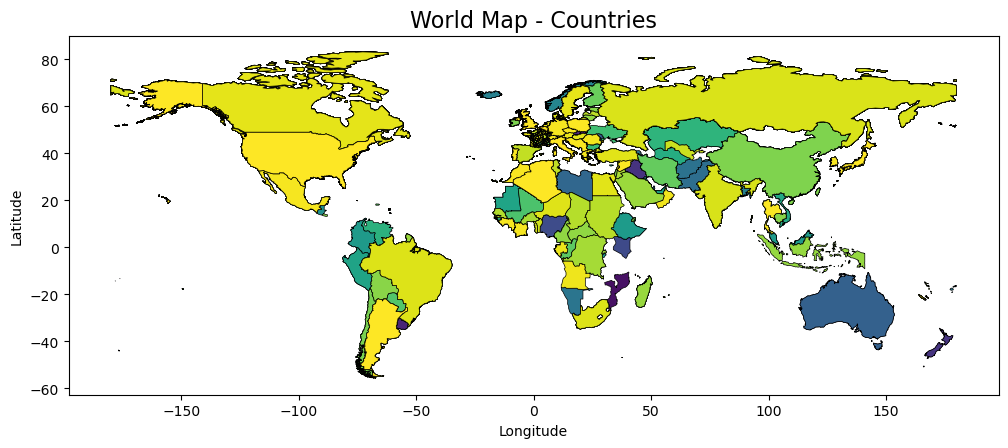

In [30]:
import geopandas as gpd

geodata = data.copy()#[data.code_pays == 'YUG']

gdf = gpd.GeoDataFrame.from_features(geodata['lieu_contours'].dropna())

fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the figure size

gdf.plot(ax=ax, cmap='viridis', edgecolor='black', linewidth=0.5, legend=True)

plt.title('World Map - Countries', fontsize=16)

# Add labels for x and y axes
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Display the plot
plt.show()


# Question 1
Under which president were there the most travels in France and abroad?

We can choose to either consider a single "travel" to be each time a country was visited, or it to be each "mission" performed (meaning considering contenu_initial), in this case we'll do the latter, allowing to consider a visit to multiple countries in few days a single "travel" instance.

In [31]:
data.head(2)

,fonction,individu,contenu_initial,lieu,lieu_normalise,pays,code_pays,date_de_debut,annee_du_voyage,date_de_fin,lieu_contours,url_de_la_notice,cote_du_dossier,geo_point_2d
0,Président de la République,François Mitterrand,Quimper le 8 octobre 1985,Quimper,Finistère (département),France,FRA,1985-10-08,1985,1985-10-08,"{'type': 'Feature', 'geometry': {'coordinates'...",http://www.siv.archives-nationales.culture.gou...,19980060/1,"{'lon': -4.059875185466053, 'lat': 48.26182594..."
1,Président de la République,François Mitterrand,Allemagne 20 juillet 1993,Allemagne,Allemagne,Allemagne,DEU,1993-07-20,1993,1993-07-20,"{'type': 'Feature', 'geometry': {'coordinates'...",http://www.siv.archives-nationales.culture.gou...,19980060/5,"{'lon': 10.400329133037499, 'lat': 51.09747327..."


In [32]:
data_filt = data.copy()

data_filt = data_filt[data_filt['fonction'] == 'Président de la République']

# we keep only one instance for each travel
data_filt = data_filt.drop_duplicates(subset=['contenu_initial'], keep='first')

In [33]:
# for total number of travels
data_filt['individu'].value_counts()

François Mitterrand         326
Jacques Chirac              187
Valéry Giscard d'Estaing    152
Charles de Gaulle           131
Georges Pompidou             54
Vincent Auriol               51
Nicolas Sarkozy              33
René Coty                     4
Name: individu, dtype: int64

In [34]:
# for number of travels in France
data_filt.loc[data_filt['code_pays']=='FRA', 'individu'].value_counts()

François Mitterrand         120
Charles de Gaulle            85
Valéry Giscard d'Estaing     80
Vincent Auriol               46
Jacques Chirac               35
Georges Pompidou             25
Nicolas Sarkozy               7
René Coty                     3
Name: individu, dtype: int64

In [35]:
# for number of travels abroad
data_filt.loc[data_filt['code_pays']!='FRA', 'individu'].value_counts()

François Mitterrand         206
Jacques Chirac              152
Valéry Giscard d'Estaing     72
Charles de Gaulle            46
Georges Pompidou             29
Nicolas Sarkozy              26
Vincent Auriol                5
René Coty                     1
Name: individu, dtype: int64

# Question 2
Are there recurrent behaviors among presidents during presidential election periods?

In [36]:
election_years = [1947, 1953, 1958, 1965, 1969, 1974, 1981, 1988, 1995, 2002, 2007, 2012, 2017, 2022]

In [37]:
data_filt = data.copy()

data_filt = data_filt[data_filt['fonction'] == 'Président de la République']

# we keep only one instance for each travel
data_filt = data_filt.drop_duplicates(subset=['contenu_initial'], keep='first')

In [38]:
def plot_travel_counts(election_counts, travel_counts):

    plt.figure(figsize=(15, 4))

    plt.bar(travel_counts.index, travel_counts.values, color='darkgrey', label='All Years')

    plt.bar(election_counts.index, election_counts.values, color='darkred', label='Election Years')

    plt.xlabel('Year')
    plt.ylabel('Travels Count')
    plt.title('Number of Travels Per Year with focus on Election years')
    plt.legend()

    plt.show()

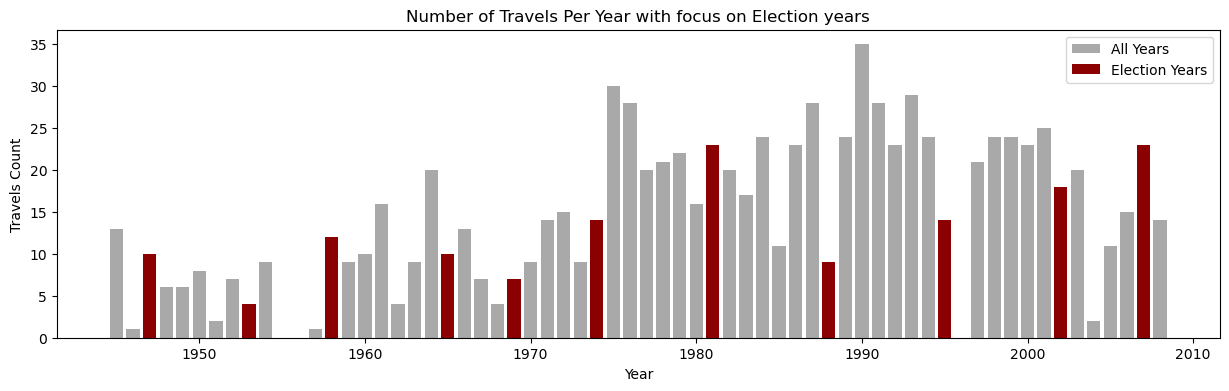

In [39]:
election_data = data_filt[data_filt.annee_du_voyage.isin(election_years)]

election_counts = election_data.annee_du_voyage.value_counts().sort_index()
travel_counts = data_filt.annee_du_voyage.value_counts().sort_index()

plot_travel_counts(election_counts, travel_counts)

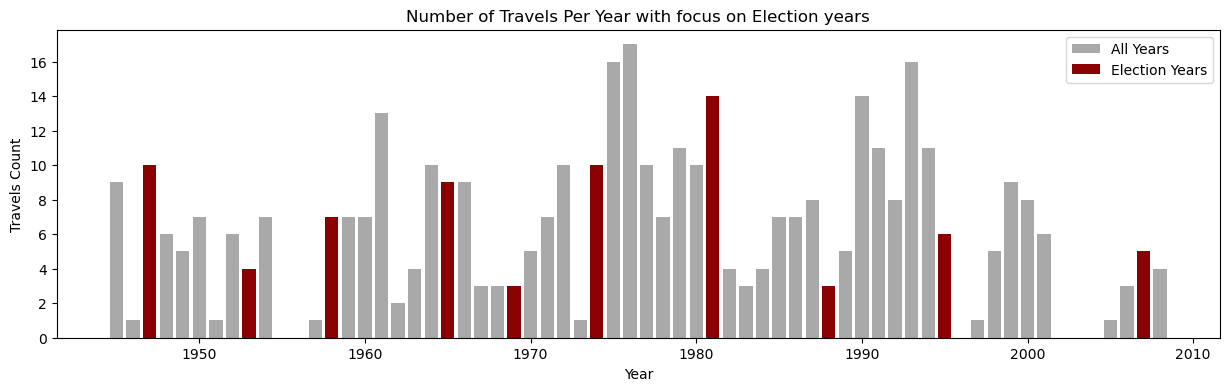

In [40]:
election_counts_FRA = election_data.loc[election_data['code_pays']=='FRA', 'annee_du_voyage'].value_counts().sort_index()
travel_counts_FRA = data_filt.loc[data_filt['code_pays']=='FRA', 'annee_du_voyage'].value_counts().sort_index()

plot_travel_counts(election_counts_FRA, travel_counts_FRA)

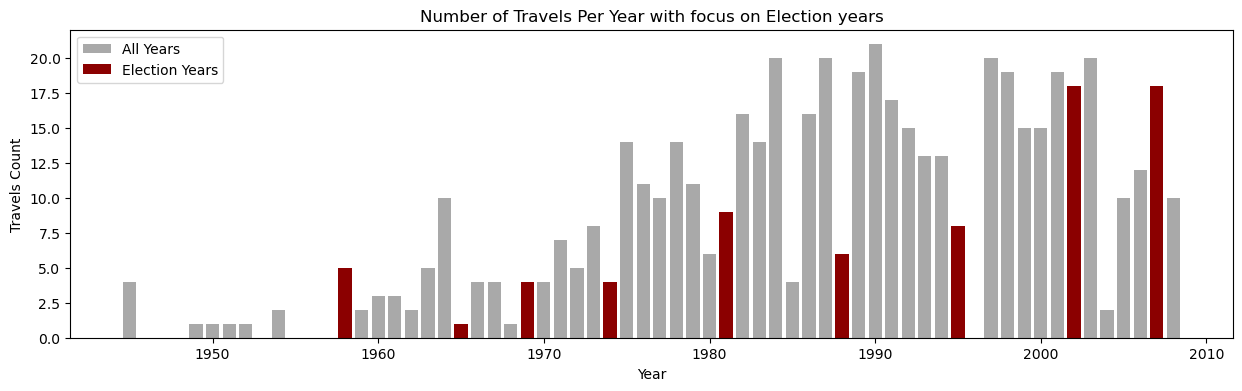

In [41]:
election_counts_OTH = election_data.loc[election_data['code_pays']!='FRA', 'annee_du_voyage'].value_counts().sort_index()
travel_counts_OTH = data_filt.loc[data_filt['code_pays']!='FRA', 'annee_du_voyage'].value_counts().sort_index()

plot_travel_counts(election_counts_OTH, travel_counts_OTH)

# Question 3
What are the most visited places in France and abroad by president and prime minister?

The top three most visited locations overall in France were:
Paris       222
Lyon         42
Poitiers     40
Name: lieu, dtype: int64


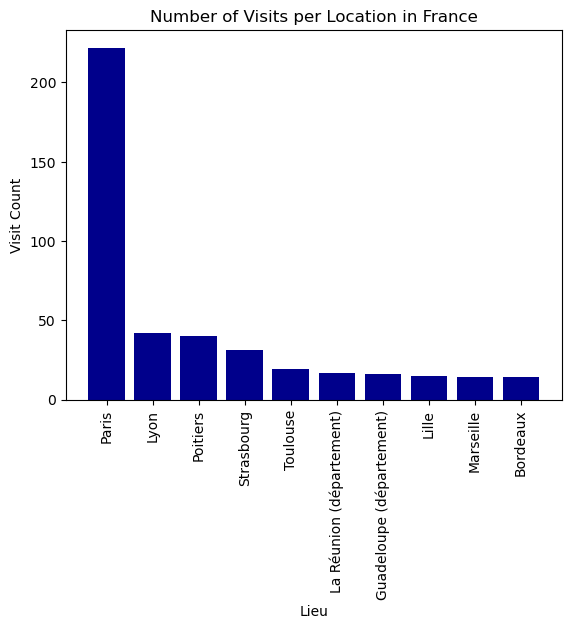

In [42]:
data_filt = data.copy()

mask = data_filt['code_pays'] == 'FRA' 

data_filt = data_filt[mask]

print(f"The top three most visited locations overall in France were:\n{data_filt['lieu'].value_counts()[:3]}")

plt.bar(data_filt['lieu'].value_counts().index[:10], data_filt['lieu'].value_counts().values[:10], color='darkblue')

plt.xlabel('Lieu')
plt.ylabel('Visit Count')
plt.title('Number of Visits per Location in France')
plt.xticks(rotation=90)

plt.show()

The top three most visited locations overall abroad were:
Bruxelles    49
Bonn         33
Londres      31
Name: lieu, dtype: int64


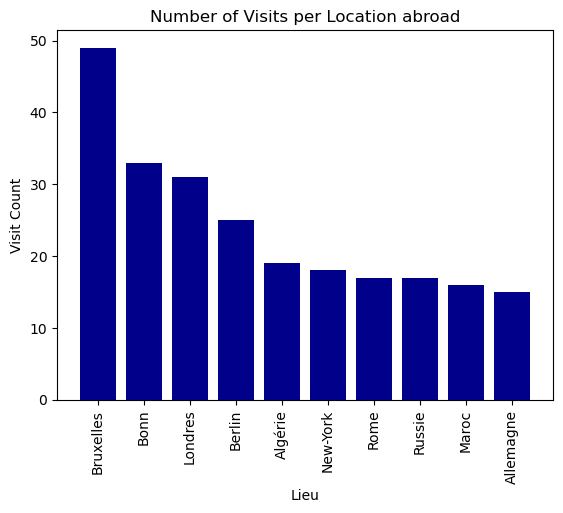

In [43]:
data_filt = data.copy()

mask = data_filt['code_pays'] != 'FRA'

data_filt = data_filt[mask]

print(f"The top three most visited locations overall abroad were:\n{data_filt['lieu'].value_counts()[:3]}")

plt.bar(data_filt['lieu'].value_counts().index[:10], data_filt['lieu'].value_counts().values[:10], color='darkblue')

plt.xlabel('Lieu')
plt.ylabel('Visit Count')
plt.title('Number of Visits per Location abroad')
plt.xticks(rotation=90)

plt.show()

# Question 4
Propose another interesting statistic and implement it 

In [44]:
data['trip_len'] = pd.to_datetime(data.date_de_fin) - pd.to_datetime(data.date_de_debut) + pd.Timedelta(days=1)

paris_coordinates = {'lat': 48.8566, 'lon': 2.3522}
data['dist'] = data.dropna().loc[:,'geo_point_2d'].apply(lambda x: geodesic(paris_coordinates.values(), (x['lat'], x['lon'])).km)

data['n_lieu_visited'] = data.groupby('contenu_initial')['contenu_initial'].transform('count')

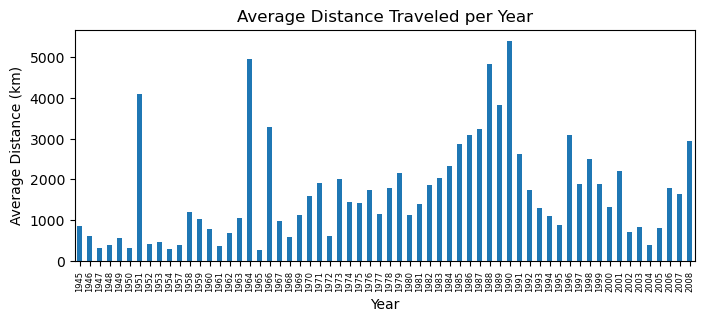

In [45]:
# average distance traveled by year

data_filt = data.copy()
data_filt = data_filt.drop_duplicates(subset=['contenu_initial'], keep='first')

average_distance_per_year = data_filt.groupby('annee_du_voyage')['dist'].mean()

plt.figure(figsize=(8, 3))

average_distance_per_year.plot(kind='bar')
plt.title('Average Distance Traveled per Year')
plt.xlabel('Year')
plt.ylabel('Average Distance (km)')
plt.xticks(size=6)
plt.show()


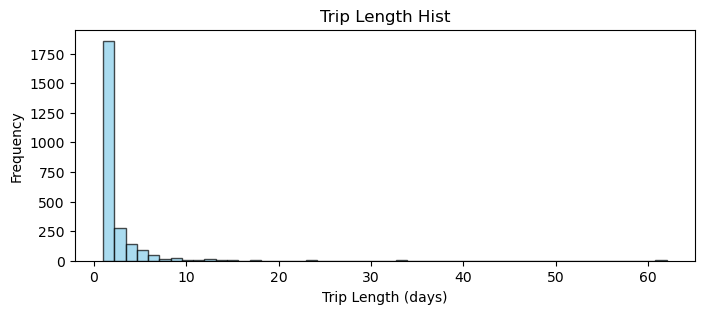

In [46]:
plt.figure(figsize=(8, 3))
plt.hist(data['trip_len'].apply(lambda x: x.days), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Trip Length Hist')
plt.xlabel('Trip Length (days)')
plt.ylabel('Frequency')
plt.show()


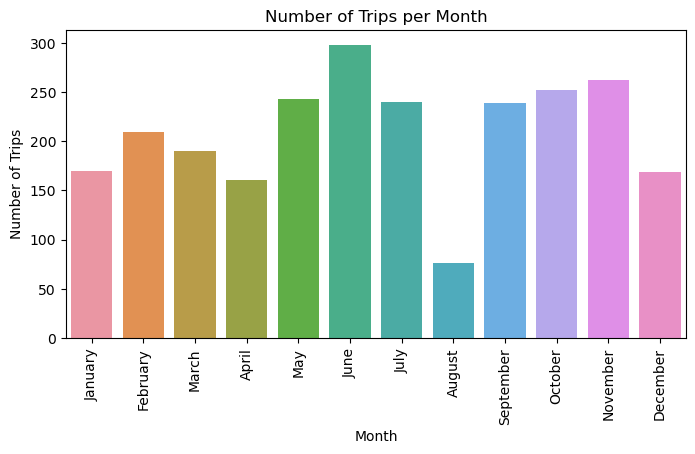

In [47]:
data['month'] = data['date_de_debut'].dt.month_name()

plt.figure(figsize=(8, 4))
sns.countplot(data=data, x='month', order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.title('Number of Trips per Month')
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.xticks(rotation=90)
plt.show()


# Question 5
Propose a method to estimate the cost of a trip.

In [48]:
def log_adj(x):
    return np.log(1 + x/100) * 3000

cost_per_night = 300
max_distance = data.groupby('contenu_initial')['dist'].max()

data['cost'] = (data['trip_len'].apply(lambda x: x.days) * cost_per_night) + (log_adj(data['contenu_initial'].map(max_distance)) * 2)

data.head()

,fonction,individu,contenu_initial,lieu,lieu_normalise,pays,code_pays,date_de_debut,annee_du_voyage,date_de_fin,lieu_contours,url_de_la_notice,cote_du_dossier,geo_point_2d,trip_len,dist,n_lieu_visited,month,cost
0,Président de la République,François Mitterrand,Quimper le 8 octobre 1985,Quimper,Finistère (département),France,FRA,1985-10-08,1985,1985-10-08,"{'type': 'Feature', 'geometry': {'coordinates'...",http://www.siv.archives-nationales.culture.gou...,19980060/1,"{'lon': -4.059875185466053, 'lat': 48.26182594...",1 days,477.760289,1,October,10823.933234
1,Président de la République,François Mitterrand,Allemagne 20 juillet 1993,Allemagne,Allemagne,Allemagne,DEU,1993-07-20,1993,1993-07-20,"{'type': 'Feature', 'geometry': {'coordinates'...",http://www.siv.archives-nationales.culture.gou...,19980060/5,"{'lon': 10.400329133037499, 'lat': 51.09747327...",1 days,628.367421,1,July,12213.812602
2,Président de la République,Jacques Chirac,"Pékin et Shangai (Chine), du 15 au 18 mai 1997",Pékin,Pékin,Chine,CHN,1997-05-15,1997,1997-05-18,"{'type': 'Feature', 'geometry': {'coordinates'...",http://www.siv.archives-nationales.culture.gou...,20160201/9,"{'lon': 103.8886221436101, 'lat': 36.519448533...",4 days,7800.545020,2,May,27417.101040
3,Président de la République,Jacques Chirac,"Tournée européenne en Belgique, au Luxembourg,...",Royaume-Uni,Royaume-Uni,Royaume-Uni,GBR,2000-11-22,2000,2000-11-30,"{'type': 'Feature', 'geometry': {'coordinates'...",http://www.siv.archives-nationales.culture.gou...,20160201/16,"{'lon': -2.857093146064205, 'lat': 54.10307884...",9 days,686.369766,14,November,21643.571151
4,Président de la République,Jacques Chirac,Sommet franco-allemand à Fribourg en Allemagne...,Fribourg,Fribourg,Allemagne,DEU,2001-06-12,2001,2001-06-12,"{'type': 'Feature', 'geometry': {'coordinates'...",http://www.siv.archives-nationales.culture.gou...,20160201/17,"{'lon': 10.400329133037499, 'lat': 51.09747327...",1 days,628.367421,1,June,12213.812602


# Question 6


In [49]:
data_filt = data.copy()
data_filt = data_filt.drop_duplicates(subset=['contenu_initial'], keep='first')

In [50]:
trip_max_cost = 100000

one_y_period = pd.DateOffset(years=1)
two_y_period = pd.DateOffset(years=2)


costs_one_y = data_filt[data_filt['date_de_debut'] >= (data_filt['date_de_debut'].max() - one_y_period)]['cost'].sum()

costs_two_y = data_filt[data_filt['date_de_debut'] >= (data_filt['date_de_debut'].max() - two_y_period)]['cost'].sum()

alerts_one_y = costs_one_y > trip_max_cost
alerts_two_y = costs_two_y > trip_max_cost

if alerts_one_y:
    print(f"Alert: Total trip cost exceeds threshold over one year.\nTotal trips cost: {costs_one_y}")

if alerts_two_y:
    print(f"Alert: Total trip cost exceeds threshold over two years.\nTotal trips cost: {costs_two_y}")

Alert: Total trip cost exceeds threshold over one year.
Total trips cost: 959671.4823958261
Alert: Total trip cost exceeds threshold over two years.
Total trips cost: 1560156.3287894782


# Question 7